## Homework 4: due 2022/05/06 23:59 (100%)

### - Tutorial : 

1. Training on MNIST: https://www.kaggle.com/code/juiyangchang/cnn-with-pytorch-0-995-accuracy
2. Torchvision transforms: https://pytorch.org/vision/stable/transforms.html
3. Pytorch leraning rate scheduler: https://pytorch.org/docs/stable/optim.html
4. How to get learning rate: https://stackoverflow.com/questions/52660985/pytorch-how-to-get-learning-rate-during-training

### - After you go through the tutorials, you should be able to work on this assignment.

### - Please answer the following questions and work directly on this jupyter notebook.

### - Make sure the code can be run and show the result and figures properly.

### - Please write down your observation with markdown in this notebook briefly.



#### You will train a multi-class classfication model in this part. The data is sampled from **Intel Image Classification Dataset**, you can find the details of each column at https://www.kaggle.com/datasets/puneet6060/intel-image-classification

In [1]:
# Import necessory modules
%matplotlib inline
import os
import glob
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as tr
import torchvision.models as models
from torch.optim.lr_scheduler import MultiStepLR
import PIL.Image as Image
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [2]:
# For reproduce the result
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### 1. Define the model and dataset (30%)

#### 1.1 Please create a class **IntelDataset** for loading the data, and a varibale ***transform*** for the preprocessing transformation should be created for later usage.  (15%)

In [3]:
class IntelDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path 
        self.categories = os.listdir(self.path)
        self.categories_id = {i:cls for i, cls in enumerate(self.categories)}
        self.data = []
        self.transform = transform
        for cls in os.listdir(self.path):
            for img in glob.glob(os.path.join(self.path, cls, "*.jpg")):
                self.data.append([img,self.categories.index(cls)])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        if self.transform!=None:
            x = self.transform(img)
        y = self.data[idx][1]
        return x, y, self.data[idx][0]
    
    def random_show(self):
        data = random.choice(self.data)
        img = self.transform(Image.open(data[0]).convert('RGB'))
        img = tr.ToPILImage()(img)
        plt.imshow(np.array(img))
        plt.title(train_dataset.categories_id[data[1]])
        plt.axis("off")
        plt.show()

#### 1.2 Please create a class **CNN** as your network with the architecture below. (15%)
##### (Note. Please determine the output layer by the task)

| Block 1 | Block 2 |  Fully Connected Layer |
|:---:|:---:|:---:|
| 3x3 conv, 64 | 3x3 conv, 128 |  Linear, 512 |
| ReLU         | ReLU   |Dropout(p=0.5)  |
| 2x2 MaxPooling, downsampling factor 2       | 2x2 MaxPooling, downsampling factor 2   | ReLU  |
|          |    |Linear, 256  |
|          |    |Dropout(p=0.5)  |
|          |    |ReLU |

In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes = 6):
        super(CNN, self).__init__()
        # Input size is set 32x32
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # The last feature map is 128x8x8
        self.fcn = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512), 
            nn.Dropout(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.Dropout(p=0.5),
            nn.ReLU(inplace=True)           
        ) 

        self.output_layer = nn.Linear(256, num_classes)
        
    def forward(self, X):
        X = self.block1(X)
        X = self.block2(X)
        X = torch.flatten(X, 1)
        X = self.fcn(X)
        X = self.output_layer(X)
        return X        

### 2. Train the model (70%)

#### 2.1 Please load the train/validation/test data from ***./animals*** respectively and resize the image to 32x32. For the data preprocessing, please apply ***RandomHorizontalFlip(p=0.5)*** and ***RandomRotation((-10,10))*** as data augmentations. Also, scale all the value in the range between 0 and 1 and normalize with mean value ***(0.485,0.456,0.406)*** and standard deviation ***(0.229,0.224,0.225)*** for RGB channel respectively. At last, create the DataLoaders with batch size 32.(10%)
##### (Note. The mean and standard deviation is calculated from ImageNet dataset) 

In [5]:
# Resize(Bilinear) to 32x32, scale to 0-1 and Normalize
train_transforms = tr.Compose([
    tr.Resize((32,32)),
    tr.RandomHorizontalFlip(p=0.5),
    tr.RandomRotation((-10, 10)),
    tr.ToTensor(), # Scale to 0-1
    tr.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
])

val_transforms = tr.Compose([
    tr.Resize((32,32)),
    tr.ToTensor(), # Scale to 0-1
    tr.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
])
# Load the dataset
train_dataset = IntelDataset("./animals/train", train_transforms)
val_dataset = IntelDataset("./animals/val", val_transforms)
test_dataset = IntelDataset("./animals/test", val_transforms)
# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### 2.2 Train the CNN model with the same hyperpameters below and do the validation every epoch. Choose the appropriate type of loss according to the task. Please record the learning rate, training/validation loss and training/validation accuracy every epoch. Also, save the model weights as ***model_without_scheduler.pth***(20%)


| | Learning rate | epochs | optimizer | weight decay | $\beta _1$|$\beta _2$|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|***Hyperparameter***| 5e-3 | 100 | Adam | 1e-2 | 0.9 | 0.99 |

In [6]:
device = "cuda:0"
num_classes = 3
model = CNN(num_classes = num_classes)
learning_rate = 0.005
criterion = nn.CrossEntropyLoss()
max_epoch = 100
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2, betas=(0.9, 0.999))
result = {"Training Loss":[], "Validation Loss":[], "Training Accuracy":[], "Validation Accuracy":[]}
pbar_epoch = tqdm(range(max_epoch))
model = model.to(device)
lr = []
for i in pbar_epoch:
    train_losses = []
    validation_losses = []
    train_cf = np.zeros((num_classes, num_classes))
    val_cf = np.zeros(((num_classes, num_classes)))
    
    # Train
    model.train()
    for inputs, label,_ in train_dataloader:
        inputs = inputs.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        pred = model(inputs)
        loss = criterion(pred, label)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        loss = loss.detach().cpu().numpy()
        
        
        
        # Calculate metrics
        label = label.cpu()
        pred = pred.detach().cpu()
        pred = torch.softmax(pred, axis=1)
        pred = torch.argmax(pred, axis=1)
        indices = num_classes * label + pred
        matrix = torch.bincount(indices, minlength=num_classes**2)
        matrix = matrix.reshape(num_classes, num_classes).numpy()
        train_cf+=matrix
    
    # Validation
    model.eval()
    for inputs, label, _ in val_dataloader:
        with torch.no_grad():
            inputs = inputs.to(device)
            label = label.to(device)
            pred = model(inputs)
            loss = criterion(pred, label)
            validation_losses.append(loss)
            loss = loss.cpu().numpy()
            
            # Calculate metrics
            label = label.cpu()
            pred = pred.detach().cpu()
            pred = torch.softmax(pred, axis=1)
            pred = torch.argmax(pred, axis=1)
            indices = num_classes * label + pred
            matrix = torch.bincount(indices, minlength=num_classes**2)
            matrix = matrix.reshape(num_classes, num_classes).numpy()
            val_cf+=matrix
    
    average_train_loss_per_epoch = torch.stack(train_losses).mean().item()
    result["Training Loss"].append(average_train_loss_per_epoch)
    average_val_loss_per_epoch = torch.stack(validation_losses).mean().item()
    result["Validation Loss"].append(average_val_loss_per_epoch)    
    pbar_epoch.set_description(f"Training loss: {average_train_loss_per_epoch:.4f} Validation Loss: {average_val_loss_per_epoch:.4f}")
    result["Training Accuracy"].append(np.trace(train_cf)/np.sum(train_cf)) 
    result["Validation Accuracy"].append(np.trace(val_cf)/np.sum(val_cf)) 
    lr.append(optimizer.param_groups[0]['lr'])

In [7]:
torch.save(model.state_dict(), "model_without_scheduler.pth")

#### 2.3 Please draw the plot the learning rate, training/validation loss and training/validation accuracy and write down the observation. (10%)
##### (Example figure)

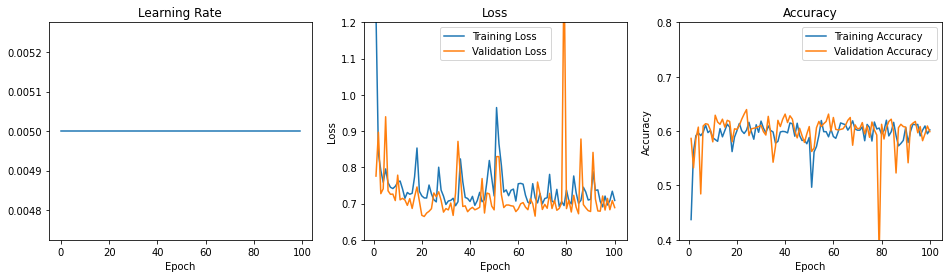

In [8]:
fig, ax = plt.subplots(1, 3, figsize = (16,4))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax[0].plot(range(len(lr)), lr)
ax[0].set_xticks(np.arange(0, len(lr)+1, 20))
ax[0].set_title("Learning Rate")
ax[0].set_xlabel("Epoch")
metrics = ["Loss", "Accuracy"]
yaxis = [([0.6,1.2], (np.arange(0.6, 1.3, 0.1))), ([0.4,0.8],(np.arange(0.4, 0.9, 0.1)))]
for i, (yt, met) in enumerate(zip(yaxis, metrics)):
    ax[i+1].set_title(met)
    ax[i+1].set_xlabel("Epoch")
    ax[i+1].set_ylabel(met)
    ax[i+1].set_xticks(np.arange(0, len(result[f"Training {met}"])+1, 20))
    ax[i+1].set_yticks(yt[1])
    ax[i+1].set_ylim(yt[0])
    ax[i+1].plot(np.arange(1, len(result[f"Training {met}"])+1), result[f"Training {met}"], label=f"Training {met}")
    ax[i+1].plot(np.arange(1, len(result[f"Validation {met}"])+1),  result[f"Validation {met}"], label=f"Validation {met}")
    ax[i+1].legend()
plt.show()

#### 2.4 Please retrain model with learning rate decay with decreasing factor 0.1 at 20 epoch and 60 epoch. The other parameters are as same as last question. Also, redraw the learning rate, accuracy and loss curves and save the weights as ***model_with_scheduler.pth***. (10%)

In [9]:
device = "cuda:0"
num_classes = 3
model = CNN(num_classes = num_classes)
learning_rate = 0.005
criterion = nn.CrossEntropyLoss()
max_epoch = 100
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-2, betas=(0.9, 0.999))
scheduler = MultiStepLR(optimizer, milestones=[20, 60], gamma=0.1) # Add learning rate scheduler
result = {"Training Loss":[], "Validation Loss":[], "Training Accuracy":[], "Validation Accuracy":[]}
pbar_epoch = tqdm(range(max_epoch))
model = model.to(device)
lr = []
for i in pbar_epoch:
    training_loss = 0
    val_loss = 0
    train_cf = np.zeros((num_classes, num_classes))
    val_cf = np.zeros(((num_classes, num_classes)))
    
    # Train
    for inputs, label, _ in train_dataloader:
        model.train()
        inputs = inputs.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        pred = model(inputs)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        loss = loss.detach().cpu().numpy()
        training_loss+=(loss)
        
        
        # Calculate metrics
        label = label.cpu()
        pred = pred.detach().cpu()
        pred = torch.softmax(pred, axis=1)
        pred = torch.argmax(pred, axis=1)
        indices = num_classes * label + pred
        matrix = torch.bincount(indices, minlength=num_classes**2)
        matrix = matrix.reshape(num_classes, num_classes).numpy()
        train_cf+=matrix
    
    # Validation
    for inputs, label, _ in val_dataloader:
        with torch.no_grad():
            model.eval()
            inputs = inputs.to(device)
            label = label.to(device)
            pred = model(inputs)
            loss = criterion(pred, label)
            loss = loss.cpu().numpy()
            val_loss+=(loss)
            
            # Calculate metrics
            label = label.cpu()
            pred = pred.detach().cpu()
            pred = torch.softmax(pred, axis=1)
            pred = torch.argmax(pred, axis=1)
            indices = num_classes * label + pred
            matrix = torch.bincount(indices, minlength=num_classes**2)
            matrix = matrix.reshape(num_classes, num_classes).numpy()
            val_cf+=matrix
    
    average_train_loss_per_epoch = training_loss/len(train_dataloader)
    result["Training Loss"].append(average_train_loss_per_epoch)
    average_val_loss_per_epoch = val_loss/len(val_dataloader)
    result["Validation Loss"].append(average_val_loss_per_epoch)    
    pbar_epoch.set_description(f"Training loss: {average_train_loss_per_epoch:.4f} Validation Loss: {average_val_loss_per_epoch:.4f}")
    result["Training Accuracy"].append(np.trace(train_cf)/np.sum(train_cf)) 
    validation_accuracy = np.trace(val_cf)/np.sum(val_cf)
    result["Validation Accuracy"].append(validation_accuracy) 
    scheduler.step() # Scheduler Update
    lr.append(scheduler.optimizer.param_groups[0]['lr'])

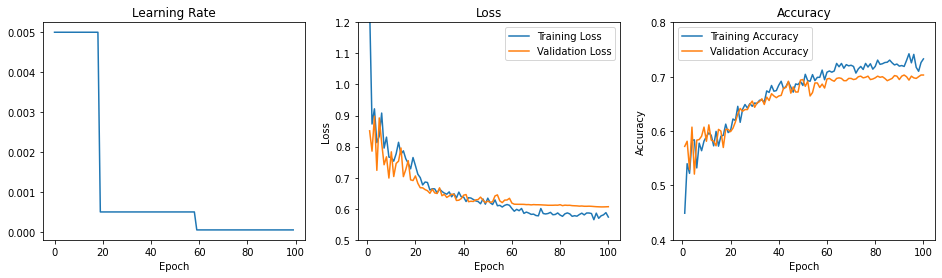

In [10]:
fig, ax = plt.subplots(1, 3, figsize = (16,4))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax[0].plot(range(len(lr)), lr)
ax[0].set_xticks(np.arange(0, len(lr)+1, 20))
ax[0].set_title("Learning Rate")
ax[0].set_xlabel("Epoch")
metrics = ["Loss", "Accuracy"]
yaxis = [([0.5,1.2], (np.arange(0.5, 1.3, 0.1))), ([0.4,0.8],(np.arange(0.4, 0.9, 0.1)))]
for i, (yt, met) in enumerate(zip(yaxis, metrics)):
    ax[i+1].set_title(met)
    ax[i+1].set_xlabel("Epoch")
    ax[i+1].set_ylabel(met)
    ax[i+1].set_xticks(np.arange(0, len(result[f"Training {met}"])+1, 20))
    ax[i+1].set_yticks(yt[1])
    ax[i+1].set_ylim(yt[0])
    ax[i+1].plot(np.arange(1, len(result[f"Training {met}"])+1), result[f"Training {met}"], label=f"Training {met}")
    ax[i+1].plot(np.arange(1, len(result[f"Validation {met}"])+1),  result[f"Validation {met}"], label=f"Validation {met}")
    ax[i+1].legend()
plt.show()

In [11]:
torch.save(model.state_dict(), "model_with_scheduler.pth")

#### 2.5 Please calculate the confusion matrix and print the accuracy of two models with the test dataset. (10%)

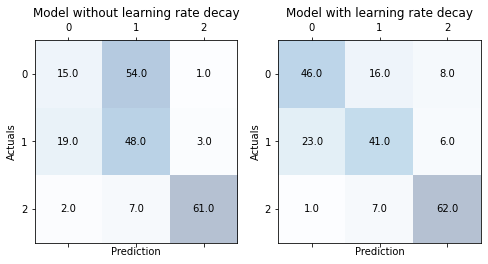

In [12]:
model1 = CNN(num_classes = num_classes)
model1.load_state_dict(torch.load("model_without_scheduler.pth"))
model1 = model1.to(device)
model2 = CNN(num_classes = num_classes)
model2.load_state_dict(torch.load("model_with_scheduler.pth"))
model2 = model2.to(device)
test_cf1 = np.zeros((num_classes,num_classes))
test_cf2 = np.zeros((num_classes,num_classes))
label_list = []
for inputs, label, _ in tqdm(test_dataloader):
    with torch.no_grad():
        model.eval()
        inputs = inputs.to(device)
        label = label.to(device)
        pred1 = model1(inputs)
        pred2 = model2(inputs)
        
        # Calculate metrics
        label = label.cpu()
        label_list += label
        pred1 = pred1.detach().cpu()
        pred1 = torch.softmax(pred1, axis=1)
        pred1 = torch.argmax(pred1, axis=1)
        indices = num_classes * label + pred1
        matrix = torch.bincount(indices, minlength=num_classes**2)
        matrix = matrix.reshape(num_classes, num_classes).numpy()
        test_cf1+=matrix
        
        pred2 = pred2.detach().cpu()
        pred2 = torch.softmax(pred2, axis=1)
        pred2 = torch.argmax(pred2, axis=1)
        indices = num_classes * label + pred2
        matrix = torch.bincount(indices, minlength=num_classes**2)
        matrix = matrix.reshape(num_classes, num_classes).numpy()
        test_cf2+=matrix

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].matshow(test_cf1, cmap=plt.cm.Blues, alpha=0.3)
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Actuals")
ax[0].set_title("Model without learning rate decay")
for j in range(test_cf1.shape[0]):
    for k in range(test_cf1.shape[1]):
        ax[0].text(x=j, y=k,s=test_cf1[k, j], va='center', ha='center')
ax[1].matshow(test_cf2, cmap=plt.cm.Blues, alpha=0.3)
ax[1].set_xlabel("Prediction")
ax[1].set_ylabel("Actuals")
ax[1].set_title("Model with learning rate decay")
for j in range(test_cf2.shape[0]):
    for k in range(test_cf2.shape[1]):
        ax[1].text(x=j, y=k,s=test_cf2[k, j], va='center', ha='center')
plt.show()

In [13]:
print("Model without learning rate decay's Accuracy: ", np.trace(test_cf1)/np.sum(test_cf1))
print("Model with learning rate decay's Accuracy: ", np.trace(test_cf2)/np.sum(test_cf2))

Model without learning rate decay's Accuracy:  0.5904761904761905
Model with learning rate decay's Accuracy:  0.7095238095238096


#### 2.6 Please choose the best model to predict the categories of images in the ***./predict*** folder and show the figure with the prediction as title of each axes. (10%)
##### (Example figure)

In [14]:
pred_list = glob.glob(os.path.join("./animals/prediction", "*.jpg"))

In [15]:
model = CNN(num_classes = num_classes)
model.load_state_dict(torch.load("model_with_scheduler.pth"))
prediction = []
img_list = []
for img_pth in pred_list:
    img = Image.open(img_pth)
    img_list.append(img)
    inputs = train_dataset.transform(img)
    inputs = torch.unsqueeze(inputs, 0)
    with torch.no_grad():
        model.eval()
        logits = model(inputs)
        pred = int(torch.argmax(logits, 1))
        prediction.append(pred)

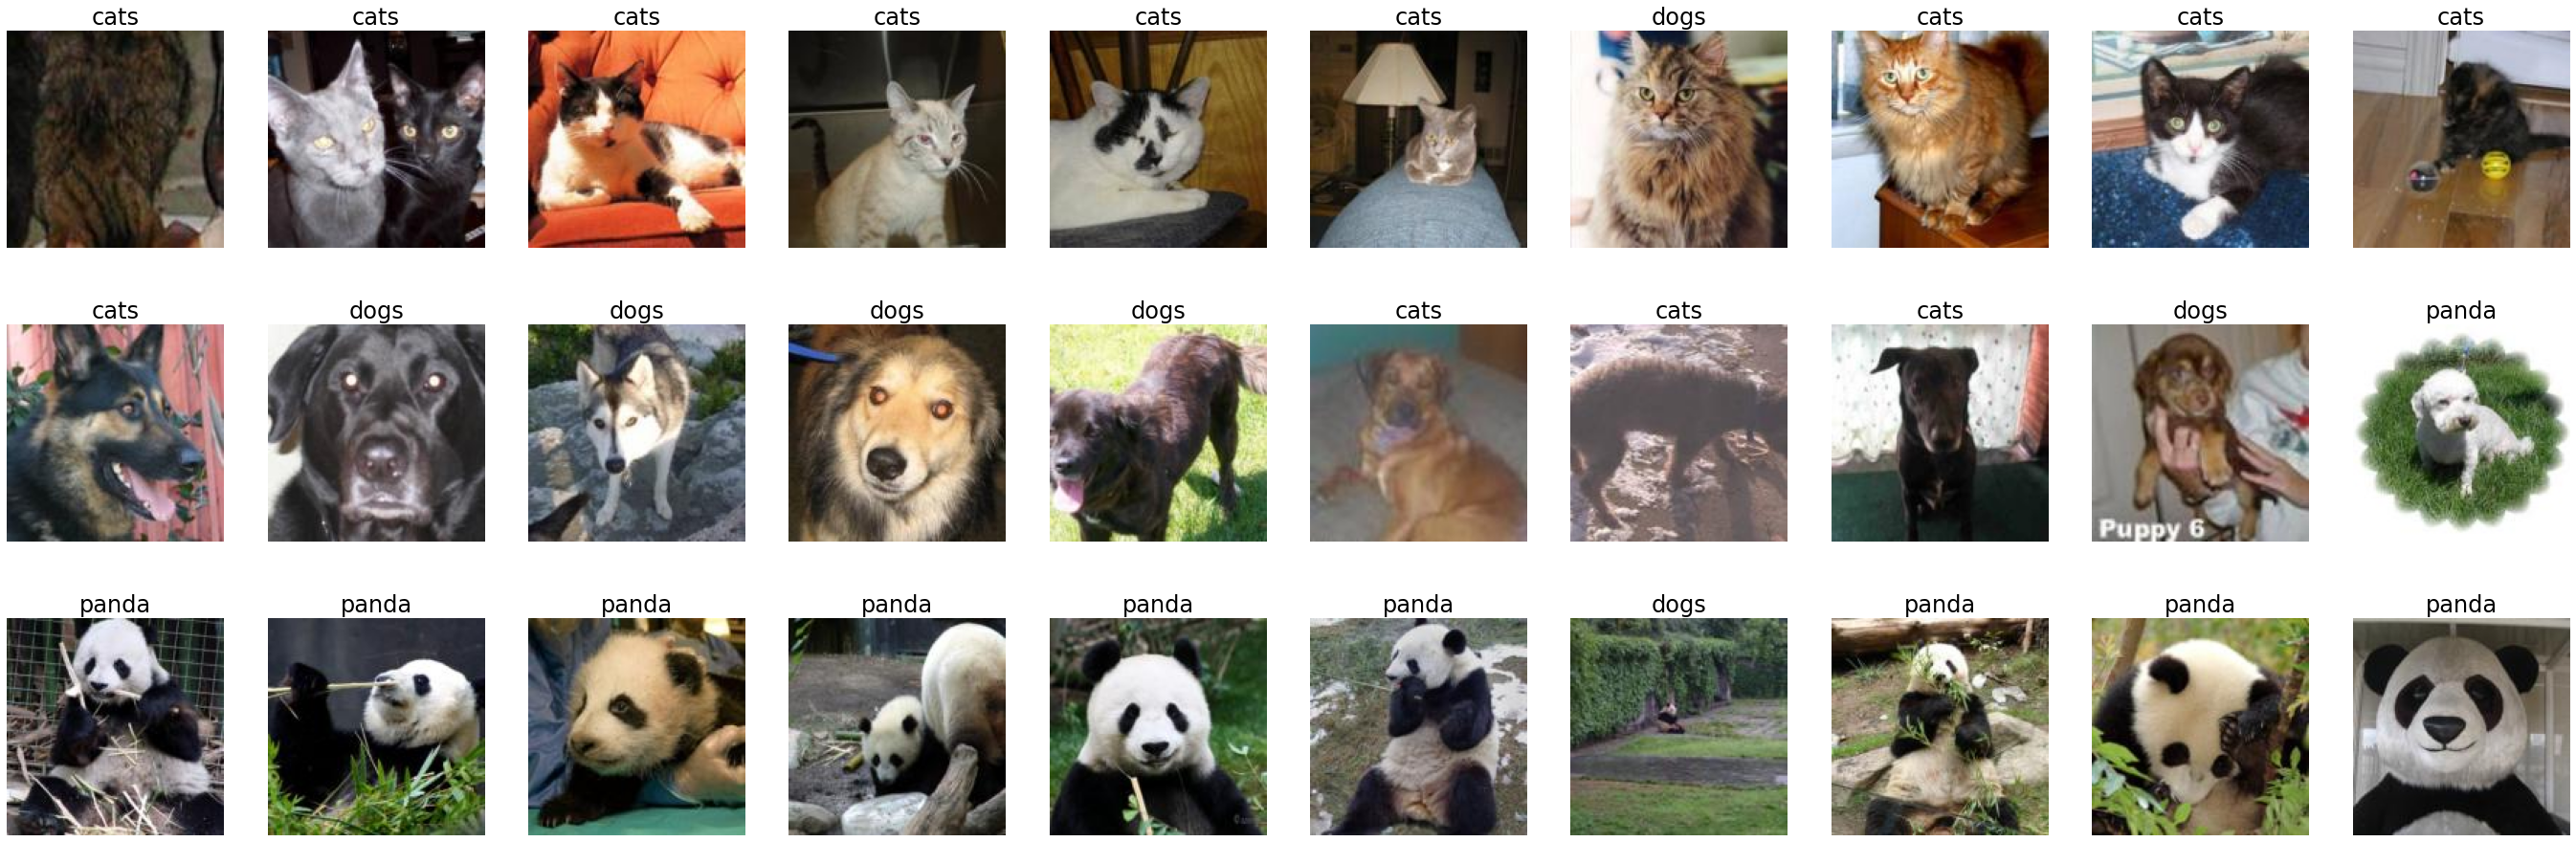

In [16]:
fig, ax = plt.subplots(3, 10, figsize = (48,16))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i, (img, cls) in enumerate(zip(img_list, prediction)):
    ax[i//10][i%10].set_title(train_dataset.categories_id[cls], fontsize = 24)
    ax[i//10][i%10].imshow(np.array(img))
    ax[i//10][i%10].axis("off")
plt.show()